In [64]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
data = pd.read_csv('finalized_county.csv')

Tarrant

In [40]:
tarrant = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
tarrant['incremental_cases'] = tarrant['incremental_cases'].astype('int')
tarrant['date'] = pd.to_datetime(tarrant['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = tarrant.iloc[:230, :]
test = tarrant.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [41]:
# Tarrant is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Tarrant is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-0.7851430797441187, 0.8234472689051321)
3199    642
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-7.253082067142602, 1.7592508012141803e-10)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

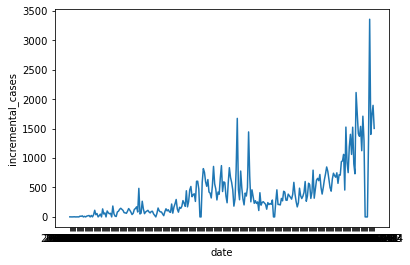

In [42]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (0, 1, 1) with MSE: 51991.810054396105


In [44]:
model = ARIMA(train.incremental_cases, order=(0, 1, 1)).fit()
pred = pd.concat([pd.Series([642]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -0.3330515591469503


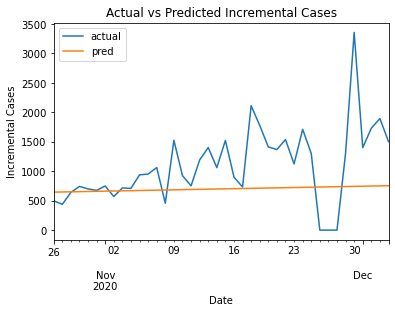

In [45]:
# Plotting

test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

ax.set_title('Actual vs Predicted Incremental Cases')

plt.show()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1539.357
Date:                Sun, 10 Mar 2024   AIC                           3082.714
Time:                        13:16:48   BIC                           3089.582
Sample:                             0   HQIC                          3085.485
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9988      0.271     -3.688      0.000      -1.530      -0.468
sigma2      3.949e+04   1.11e+04      3.566      0.000    1.78e+04    6.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.15   Jarque-Bera (JB):               892.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.82   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
#Harris

In [65]:
harris = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
harris['incremental_cases'] = harris['incremental_cases'].astype('int')
harris['date'] = pd.to_datetime(harris['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = harris.iloc[:230, :]
test = harris.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [66]:
# Tarrant is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Tarrant is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-2.2416106051506035, 0.19149116285834866)
2929    379
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-8.652159828218712, 5.0809546880530815e-14)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

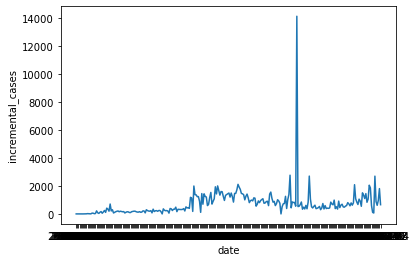

In [67]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (1, 1, 2) with MSE: 2364070.483221221


In [69]:
model = ARIMA(train.incremental_cases, order=(1, 1, 2)).fit()
pred = pd.concat([pd.Series([379]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -0.06316272840988213


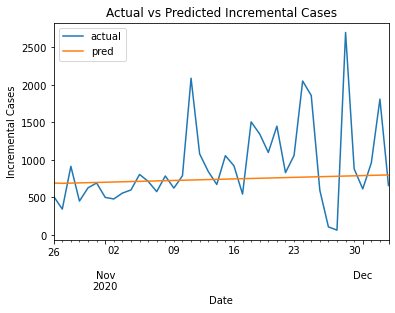

In [70]:
# Plotting

test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

ax.set_title('Actual vs Predicted Incremental Cases')

plt.show()

In [71]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1904.990
Date:                Wed, 13 Mar 2024   AIC                           3817.979
Time:                        00:23:24   BIC                           3831.714
Sample:                             0   HQIC                          3823.520
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0246      0.056     -0.442      0.659      -0.134       0.085
ma.L1         -1.9105      0.034    -55.434      0.000      -1.978      -1.843
ma.L2          0.9105      0.035     26.334      0.000       0.843       0.978
sigma2      9.401e+05   7.01e-08   1.34e+13      0.000     9.4e+05     9.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            206114.76
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             267.48   Skew:                            10.89
Prob(H) (two-sided):                  0.00   Kurtosis:                       148.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+28. Standard errors may be unstable.
"""

In [55]:
#Philadelphia

In [72]:
philly = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
philly['incremental_cases'] = philly['incremental_cases'].astype('int')
philly['date'] = pd.to_datetime(philly['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = philly.iloc[:230, :]
test = philly.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


In [73]:
# Philadelphia is non-stationary
print("Stationary or not?:", stationary_test(train.incremental_cases))

# get this value for reversion purposes
print(train.loc[train['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
train['incremental_cases'] = train['incremental_cases'].diff(
).fillna(train['incremental_cases']).astype('int')

# Philadelphia is stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(train.incremental_cases))

Stationary or not?: (-2.587596964172684, 0.09558791429258168)
2659    0
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-3.2081320654001626, 0.01951876252889616)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

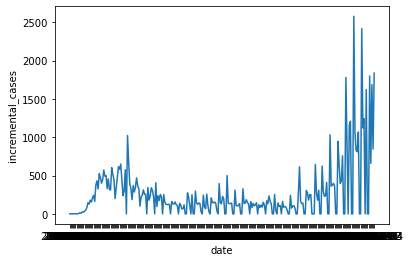

In [74]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [75]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (3, 1, 5) with MSE: 23967.937672930177


In [76]:
model = ARIMA(train.incremental_cases, order=(3, 1, 5)).fit()
pred = pd.concat([pd.Series([0]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -0.41652064400386846


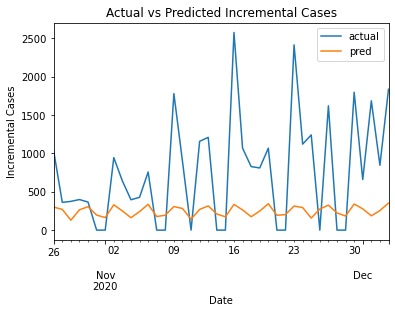

In [77]:
# Plotting

test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

ax.set_title('Actual vs Predicted Incremental Cases')

plt.show()

In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -1442.550
Date:                Sun, 10 Mar 2024   AIC                           2903.100
Time:                        13:17:30   BIC                           2934.004
Sample:                             0   HQIC                          2915.568
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4328      0.061    -23.406      0.000      -1.553      -1.313
ar.L2         -1.4315      0.039    -36.946      0.000      -1.507      -1.356
ar.L3         -0.9906      0.061    -16.290      0.000      -1.110      -0.871
ma.L1         -0.4538      0.094     -4.831      0.000      -0.638      -0.270
ma.L2         -0.3287      0.151     -2.181      0.029      -0.624      -0.033
ma.L3         -0.3851      0.151     -2.546      0.011      -0.682      -0.089
ma.L4         -0.5827      0.147     -3.955      0.000      -0.871      -0.294
ma.L5          0.8211      0.109      7.556      0.000       0.608       1.034
sigma2      2.131e+04   2333.949      9.129      0.000    1.67e+04    2.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):               156.05
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.42
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""